# Main code for the project "Identify Fraud from Enron Mail"

## Preparation

In [1]:
# Import needed libraries
import sys
import pickle
sys.path.append('../tools/')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pprint

In [2]:
# Import feature_format and tester function. 
# They were modified so that to run with Python 3.7. Can be found in attachment.
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

## Step 1a: Overview of  the initial dataset

In [3]:
### Load the dictionary containing the dataset
with open('final_project_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)

In [4]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

In [5]:
# Format of the data?
type(my_dataset)

dict

In [6]:
# Nb of samples?
len(my_dataset)

146

There are 146 people (i.e. samples in the dataset). Let's have a look at one sample:

In [7]:
# Get the value of 1 key of the dictionary
next(iter(my_dataset.keys()))

'METTS MARK'

In [8]:
# Get the value associated to this key
next(iter(my_dataset.values()))

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

In [9]:
# The features of each samples are stored in a dictionary.
# Nb of features?
len(next(iter(my_dataset.values())))

21

We can check that, as stated in the project details page, each sample has:
- 1 label (poi)
- 14 financial features
- 6 email features

In [10]:
# How many POI in the dataset?
nb_NaN = 0
nb_POI = 0
nb_non_POI = 0

for k in my_dataset.keys():
    if my_dataset[k]['poi'] == 'NaN':
        nb_NaN +=1
    elif my_dataset[k]['poi']:
        nb_POI +=1
    elif not my_dataset[k]['poi']:
        nb_non_POI +=1

In [11]:
print('Status on samples labels. NaN: {} , POI: {}  , Not POI: {}'.format(nb_NaN,nb_POI,nb_non_POI))

Status on samples labels. NaN: 0 , POI: 18  , Not POI: 128


Good piece of news is that we have the POI label for all the datapoint. 
Bad piece of news is taht the classes are strongly imbalanced. This will make us use a stratified shuffling method while validating the classifiers we propose. 

## Step 1b: Further exploration of the features

To go further with the exploration of the available features (missing values, outliers...) we create to visualize them:

In [12]:
def feature_explore (dataset_dict,feature,unit):
    '''Function that take the dataset dictionary, one of its numerical features, and its unit as inputs
    and returns the following, for the POI and non POI sub-groups:
    - count of NaN
    - min value
    - max value
    - mean value
    The box plot and histogram are also plotted for the whole data (POI and non POI together)'''
    # initialize list of values, when existing
    val = []
    # initialize assiated list POI (True --> 1; False --> 0)
    val_POI = []
    # initialize count of NaN, for POI and non POI
    NaN_POI_nb = 0
    NaN_nonPOI_nb = 0 
    
    for k in my_dataset.keys():
        if my_dataset[k][feature] == 'NaN':
            if my_dataset[k]['poi'] == True:
                NaN_POI_nb += 1
            else:
                NaN_nonPOI_nb += 1
        else:
            val.append(int(my_dataset[k][feature]))
            if my_dataset[k]['poi'] == True:
                val_POI.append(1)
            else:
                val_POI.append(0)
    
    # Convert to numpy arrays for later calculations
    val = np.array(val)
    val_POI = np.array(val_POI)
    
    # Compute and display count of NaN, min, max, mean for POI and non POI
    print('Feature: {} ({})'.format(feature,unit))
    print('Count of NaN - POI: {:d} \t\t non-POI: {:d}'.format(NaN_POI_nb,NaN_nonPOI_nb))
    print('Min value    - POI: {:d} \t non-POI: {:d}'.format(min(val[val_POI==1]),min(val[val_POI==0])))
    print('Max value    - POI: {:d} \t non-POI: {:d}'.format(max(val[val_POI==1]),max(val[val_POI==0])))
    print('Mean value   - POI: {:.0f} \t non-POI: {:.0f}'.format(np.mean(val[val_POI==1]),np.mean(val[val_POI==0])))
    
    # Box plot and histogram
    green_diamond = dict(markerfacecolor='g', marker='D')
    plt.figure(figsize=(10,5))            
    ax1 = plt.subplot(121)
    ax1.boxplot([val[val_POI==1],val[val_POI==0]], flierprops=green_diamond)
    plt.xticks([1, 2], ['POI','non POI'])
    plt.ylabel(feature+' '+unit)
    
    ax2 = plt.subplot(122)
    ax2.hist([val[val_POI==1],val[val_POI==0]],alpha=0.8,bins=25)
    plt.xlabel(feature+' '+unit)
    plt.ylabel('count')
    plt.legend(['POI','non POI'])
    

Now we use this function on the financial features, beginning with the salary:

Feature: salary ($)
Count of NaN - POI: 1 		 non-POI: 50
Min value    - POI: 158403 	 non-POI: 477
Max value    - POI: 1111258 	 non-POI: 26704229
Mean value   - POI: 383445 	 non-POI: 601152


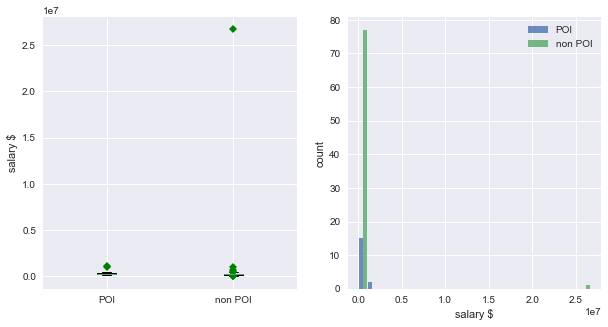

In [13]:
feature_explore (my_dataset,'salary','$')

There is an obvious outlier, which correspond to the salary of a non POI. To be able to find the name of outliers, we create another simple function:

In [14]:
def display_records(dataset_dict,feature,threshold,above = True):
    '''Function that take the dataset dictionary, one of its numerical features, and a threshold as inputs
    and returns the samples (people records) whose feature is above (above = True) or below (above = False) the 
    given threshold'''
    if above:
        for k in my_dataset.keys():
            if my_dataset[k][feature] != 'NaN' and int(my_dataset[k][feature]) >= threshold:
                print(k)
                pprint.pprint(my_dataset[k])
                print('')
    else:
        for k in my_dataset.keys():
            if my_dataset[k][feature] != 'NaN' and int(my_dataset[k][feature]) <= threshold:
                print(k)
                pprint.pprint(my_dataset[k])
                print('')

We use this function to find the non POI salary outlier: 

In [15]:
display_records(my_dataset,'salary',2.5e7)

TOTAL
{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}



We find that the identified outlier is not a person but a sample that contains the total for the financial features. We pop it from the dictionary and repeat the process.

In [16]:
print(len(my_dataset))
my_dataset.pop('TOTAL')
print(len(my_dataset))

146
145


### "Promising" financial features

Feature: salary ($)
Count of NaN - POI: 1 		 non-POI: 50
Min value    - POI: 158403 	 non-POI: 477
Max value    - POI: 1111258 	 non-POI: 1060932
Mean value   - POI: 383445 	 non-POI: 262152


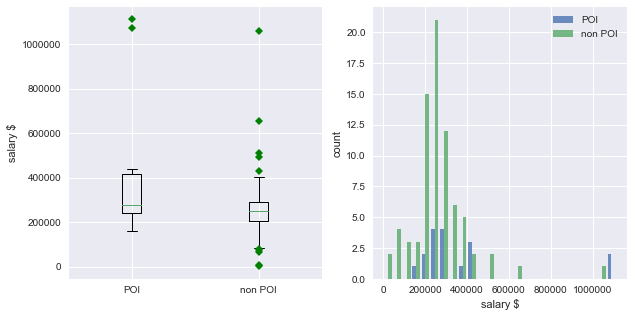

In [17]:
feature_explore (my_dataset,'salary','$')

Several interesting points:
- one third of the salary data is missing, but at least we have it for all the POI except 1
- the median salary of the POI sugroup is higher than that of the non POI subgroup. Intersting feature for our classifier!
- 3 clear outliers: 2 POI and 1 non POI
- the 'shape' of the salary distribution seems to be quite similar for POI and non POI 

Let's have a look at the 3 clear outliers mentioned above:

In [18]:
display_records(my_dataset,'salary',1e6)

LAY KENNETH L
{'bonus': 7000000,
 'deferral_payments': 202911,
 'deferred_income': -300000,
 'director_fees': 'NaN',
 'email_address': 'kenneth.lay@enron.com',
 'exercised_stock_options': 34348384,
 'expenses': 99832,
 'from_messages': 36,
 'from_poi_to_this_person': 123,
 'from_this_person_to_poi': 16,
 'loan_advances': 81525000,
 'long_term_incentive': 3600000,
 'other': 10359729,
 'poi': True,
 'restricted_stock': 14761694,
 'restricted_stock_deferred': 'NaN',
 'salary': 1072321,
 'shared_receipt_with_poi': 2411,
 'to_messages': 4273,
 'total_payments': 103559793,
 'total_stock_value': 49110078}

SKILLING JEFFREY K
{'bonus': 5600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'jeff.skilling@enron.com',
 'exercised_stock_options': 19250000,
 'expenses': 29336,
 'from_messages': 108,
 'from_poi_to_this_person': 88,
 'from_this_person_to_poi': 30,
 'loan_advances': 'NaN',
 'long_term_incentive': 1920000,
 'other': 22122,
 'poi': T

The 2 POIs are Kenneth Lay and Jeffrey Skilling, respectively Chairman of the Board of Directors and COO of Enron when the scandal occured.
The non POI is Mark Frevert, Enron vice chairman.

Now let's look at the other financial features:

Feature: bonus ($)
Count of NaN - POI: 2 		 non-POI: 62
Min value    - POI: 200000 	 non-POI: 70000
Max value    - POI: 7000000 	 non-POI: 8000000
Mean value   - POI: 2075000 	 non-POI: 986825


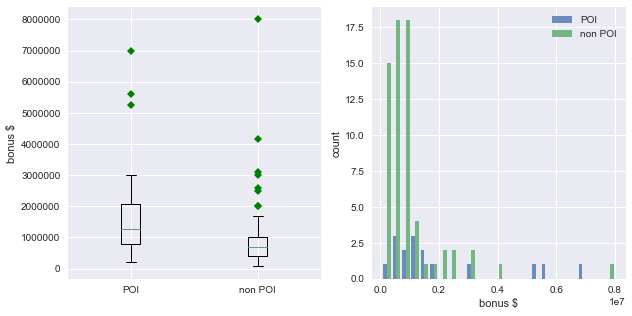

In [19]:
feature_explore (my_dataset,'bonus','$')

Feature: restricted_stock ($)
Count of NaN - POI: 1 		 non-POI: 35
Min value    - POI: 126027 	 non-POI: -2604490
Max value    - POI: 14761694 	 non-POI: 13847074
Mean value   - POI: 2318621 	 non-POI: 931007


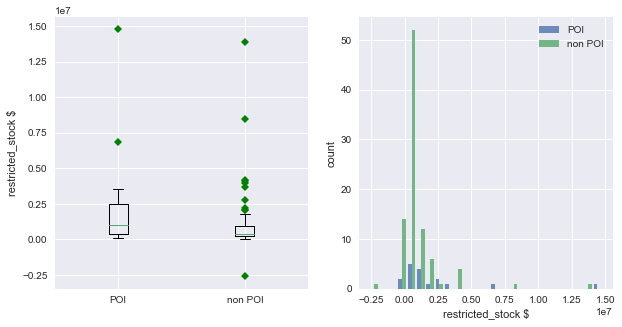

In [20]:
feature_explore (my_dataset,'restricted_stock','$')

Feature: exercised_stock_options ($)
Count of NaN - POI: 6 		 non-POI: 38
Min value    - POI: 384728 	 non-POI: 3285
Max value    - POI: 34348384 	 non-POI: 15364167
Mean value   - POI: 10463794 	 non-POI: 1947752


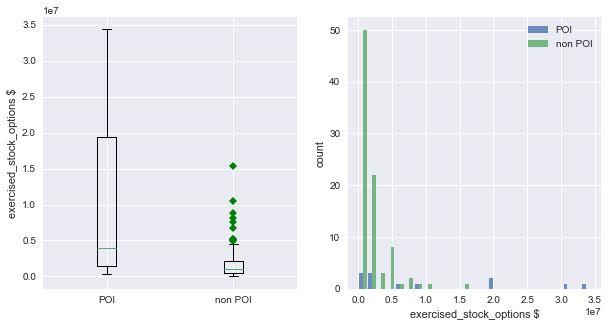

In [21]:
feature_explore (my_dataset,'exercised_stock_options','$')

Feature: long_term_incentive ($)
Count of NaN - POI: 6 		 non-POI: 74
Min value    - POI: 71023 	 non-POI: 69223
Max value    - POI: 3600000 	 non-POI: 5145434
Mean value   - POI: 1204862 	 non-POI: 642709


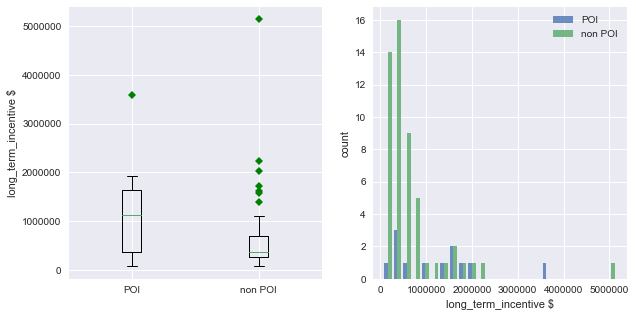

In [22]:
feature_explore (my_dataset,'long_term_incentive','$')

The 'salary', 'bonus', 'restricted stock', 'exercised_stock_options' and 'long_term_incentive' features do not have too many missing values, and they seem to be able to help distinguish between POIs and non-POIs.

### 'expenses' and 'other'

Feature: expenses ($)
Count of NaN - POI: 0 		 non-POI: 51
Min value    - POI: 16514 	 non-POI: 148
Max value    - POI: 127017 	 non-POI: 228763
Mean value   - POI: 59874 	 non-POI: 52846


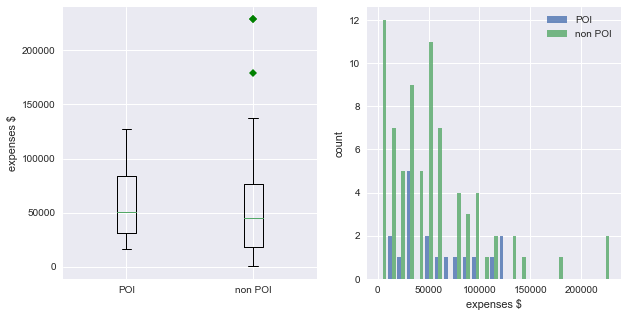

In [23]:
feature_explore (my_dataset,'expenses','$')

Feature: other ($)
Count of NaN - POI: 0 		 non-POI: 53
Min value    - POI: 486 	 non-POI: 2
Max value    - POI: 10359729 	 non-POI: 7427621
Mean value   - POI: 802997 	 non-POI: 383128


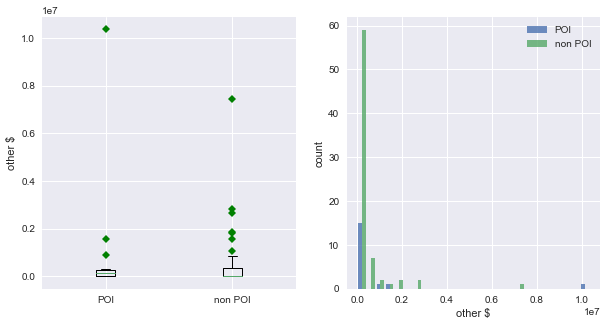

In [24]:
feature_explore (my_dataset,'other','$')

For the 'other' feature, the 2 main outliers are again Kenneth Lay (POI) and Mark Frevert (non POI).

The 'expenses' and 'other' financial features do not seem to bring any useful information to distinguish between POIs and non POIs.

### Features with many missing values

Feature: deferred_income ($)
Count of NaN - POI: 7 		 non-POI: 90
Min value    - POI: -3504386 	 non-POI: -3367011
Max value    - POI: -833 	 non-POI: -1042
Mean value   - POI: -1035313 	 non-POI: -445998


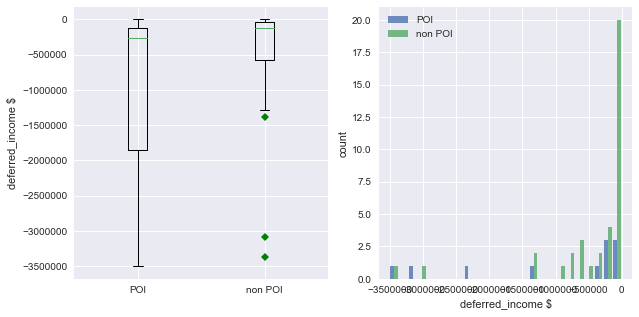

In [25]:
feature_explore (my_dataset,'deferred_income','$')

Too many missing data, in particular for the POIs.

Feature: deferral_payments ($)
Count of NaN - POI: 13 		 non-POI: 94
Min value    - POI: 10259 	 non-POI: -102500
Max value    - POI: 2144013 	 non-POI: 6426990
Mean value   - POI: 519894 	 non-POI: 890346


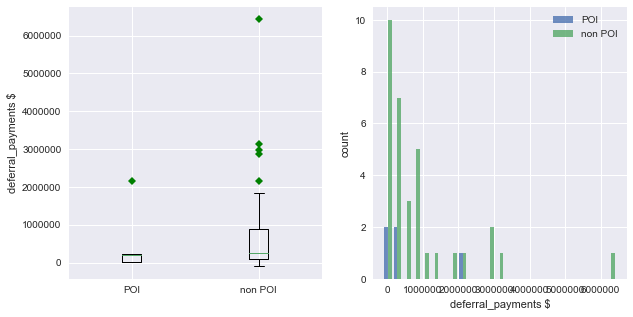

In [26]:
feature_explore (my_dataset,'deferral_payments','$')

Same comment for 'deferral_payments'...

Feature: loan_advances ($)
Count of NaN - POI: 17 		 non-POI: 125
Min value    - POI: 81525000 	 non-POI: 400000
Max value    - POI: 81525000 	 non-POI: 2000000
Mean value   - POI: 81525000 	 non-POI: 1200000


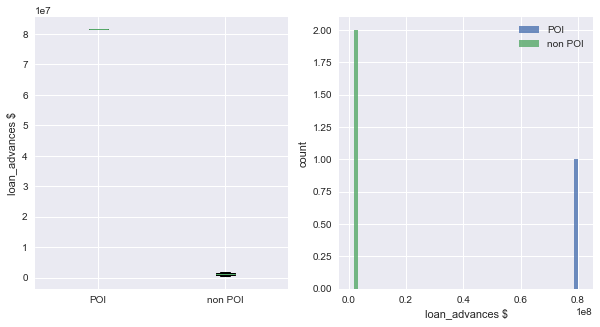

In [27]:
feature_explore (my_dataset,'loan_advances','$')

Only 1 POI has a value for 'loan_advances': we cannot generalize with this feature.

In [28]:
# feature_explore (my_dataset,'director_fees','$')

In [29]:
# feature_explore (my_dataset,'restricted_stock_deferred','$')

The feature_explore function gives a ValueError with the 'director_fees' and 'restricted_stock_deferred' financial features because we have no value for theses feature for all the POIs ! They will definitely not be useful for our classifier.

Too few data (notably for the POIs) for the following financial features: loan_advances, director_fees, deferral_payments, deferred_income, restricted_stock_deferred .

### 'Total' financial features

Feature: total_payments ($)
Count of NaN - POI: 0 		 non-POI: 21
Min value    - POI: 91093 	 non-POI: 148
Max value    - POI: 103559793 	 non-POI: 17252530
Mean value   - POI: 7913590 	 non-POI: 1725091


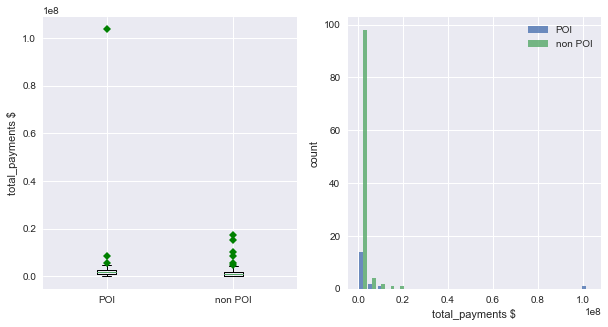

In [30]:
feature_explore (my_dataset,'total_payments','$')

There is a very clear outlier, from the POI subgroup: Kenneth Ley. 

Feature: total_stock_value ($)
Count of NaN - POI: 0 		 non-POI: 20
Min value    - POI: 126027 	 non-POI: -44093
Max value    - POI: 49110078 	 non-POI: 23817930
Mean value   - POI: 9165671 	 non-POI: 2374085


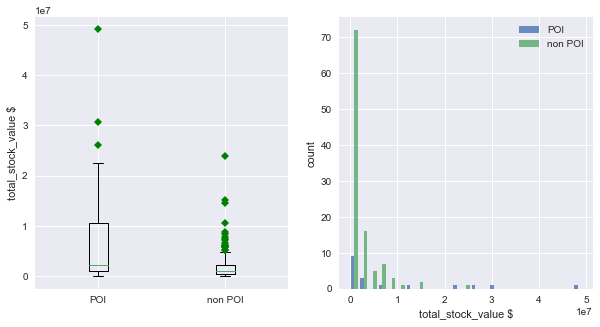

In [31]:
feature_explore (my_dataset,'total_stock_value','$')

For the financial features, **we will test 2 strategies**:
- **strategy A**: we keep only the 2 overall features, i.e. 'total_payments' and 'total_stock_value'. By summing the different financial features, we ensure that we have a value for a maximum number of people.
- **strategy B**: we disregard:
    - the 'total' features, because by summing different kinds of financial quantities we believe they might 'dilute' the information we need to distinguish between POIs and non POIs.
    - the features for which there were too many missing values: 'loan_advances', 'director_fees', 'deferral_payments', 'deferred_income', 'restricted_stock_deferred'
    - the features for which we saw that there was not a significant difference between POIs and non-POIs: 'other',  'expenses'

Whatever the strategy, **we decide to keep the outliers** of the selected features. Indeed, we saw that there were at least two very emblematic POIs, Kenneth Lay and Jeffrey Skilling, who presented outliers for one or several financial features. Given the limited number of POIs in the dataset, we don't want to further reduce their proportion in the data that will be used to train the algorithm. 

### Email features

Feature: from_messages ()
Count of NaN - POI: 4 		 non-POI: 55
Min value    - POI: 16 	 non-POI: 12
Max value    - POI: 3069 	 non-POI: 14368
Mean value   - POI: 300 	 non-POI: 669


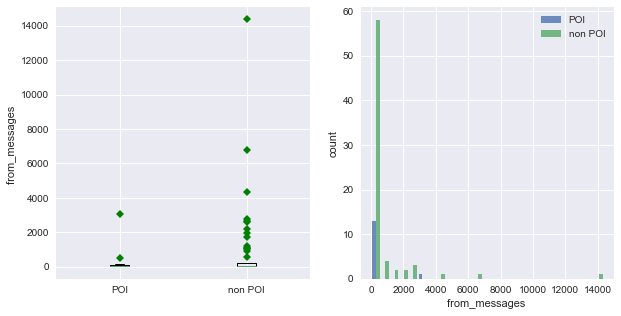

In [32]:
feature_explore (my_dataset,'from_messages','')

Feature: to_messages ()
Count of NaN - POI: 4 		 non-POI: 55
Min value    - POI: 225 	 non-POI: 57
Max value    - POI: 7991 	 non-POI: 15149
Mean value   - POI: 2417 	 non-POI: 2007


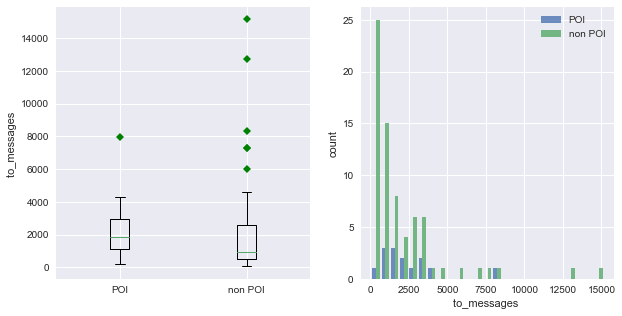

In [33]:
feature_explore (my_dataset,'to_messages','')

Feature: from_this_person_to_poi ()
Count of NaN - POI: 4 		 non-POI: 55
Min value    - POI: 4 	 non-POI: 0
Max value    - POI: 609 	 non-POI: 411
Mean value   - POI: 67 	 non-POI: 36


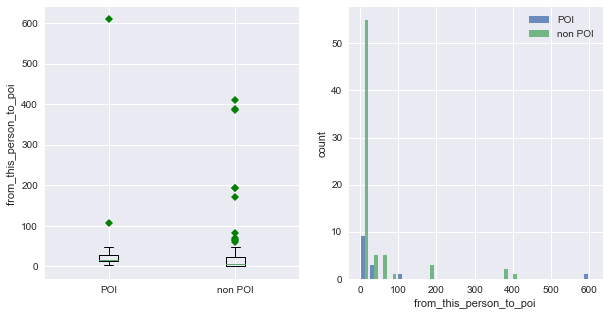

In [34]:
feature_explore (my_dataset,'from_this_person_to_poi','')

Feature: from_poi_to_this_person ()
Count of NaN - POI: 4 		 non-POI: 55
Min value    - POI: 13 	 non-POI: 0
Max value    - POI: 240 	 non-POI: 528
Mean value   - POI: 98 	 non-POI: 58


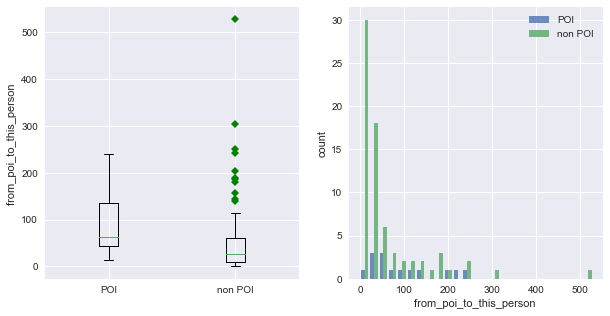

In [35]:
feature_explore (my_dataset,'from_poi_to_this_person','')

Feature: shared_receipt_with_poi ()
Count of NaN - POI: 4 		 non-POI: 55
Min value    - POI: 91 	 non-POI: 2
Max value    - POI: 5521 	 non-POI: 4527
Mean value   - POI: 1783 	 non-POI: 1059


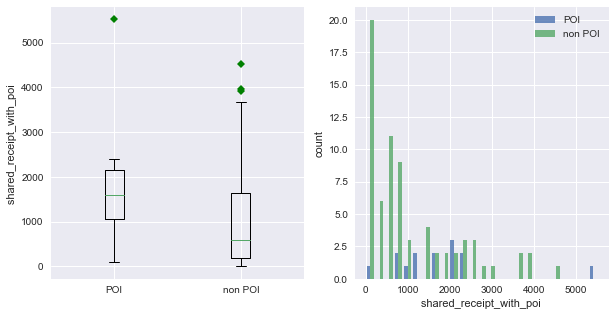

In [36]:
feature_explore (my_dataset,'shared_receipt_with_poi','')

In the frame of our POI identifier algorithm, there is no need to use the 'email_address' feature.

At first sight, the 'shared_receipt_with_poi' email feature looks promising. 

On the other hand, the 'from_this_person_to_poi' and 'from_poi_to_this_person' features might not be so expressive if we don't 'normalize' them by the total 'from_message' and 'to_message' respectively. Indeed, if we make the assumption that the fraud system was established by a limited number of people who know each others, then it is not the absolute number of mails send to or received from a POI that matters, but the ration to the total mailbox. If A and B send 30% and 5% of their emails to C respectively, then C is likely to be closer to A than B. Later on, we will check this intuition by using the original poi email features, then replacing them by the 'relative' poi email features, and comparing the erformance of teh POI identifier algorithm.


## Step 2: Feature selecion and engineering

### Create relative POI email features
As explained above, we use the piece of code below to compute, for each person of the dataset:
- the ratio of emails sent to a POI over total number of sent emails
- the ratio of emails received from a POI over the total number of received emails

In [37]:
for k in my_dataset.keys():
    if my_dataset[k]['from_poi_to_this_person'] != 'NaN' and my_dataset[k]['to_messages'] != 'NaN':
        my_dataset[k]['relative_from_poi_to_this_person'] = \
        float(my_dataset[k]['from_poi_to_this_person'])/float(my_dataset[k]['to_messages'])
    else: 
        my_dataset[k]['relative_from_poi_to_this_person'] = 'NaN'
        
    if my_dataset[k]['from_this_person_to_poi'] != 'NaN' and my_dataset[k]['from_messages'] != 'NaN':
        my_dataset[k]['relative_from_this_person_to_poi'] = \
        float(my_dataset[k]['from_this_person_to_poi'])/float(my_dataset[k]['from_messages'])
    else:
        my_dataset[k]['relative_from_this_person_to_poi'] = 'NaN'

Now let's have a look at these new features by making a scatter plot:

In [38]:
# Create matrix X with the 2 'relative' POI email features, and vector y of labels
X = []
y = []

for k in my_dataset.keys():
    if my_dataset[k]['relative_from_poi_to_this_person'] != 'NaN' and \
    my_dataset[k]['relative_from_this_person_to_poi'] != 'NaN':
        X.append([my_dataset[k]['relative_from_poi_to_this_person'],my_dataset[k]['relative_from_this_person_to_poi']])
        if my_dataset[k]['poi']:
            y.append(1)
        else:
            y.append(0)

X = np.array(X)
y = np.array(y)

We then use the short scatter plot function below:

In [39]:
def plot2Dscatter(X,y,features,labels):
    plt.scatter(X[y == labels[0],0], X[y == labels[0],1], color = 'b', label=str(labels[0]))
    plt.scatter(X[y == labels[1],0], X[y == labels[1],1], color = 'r', label=str(labels[1]))
    plt.legend()
    plt.xlabel(features[0])
    plt.ylabel(features[1])

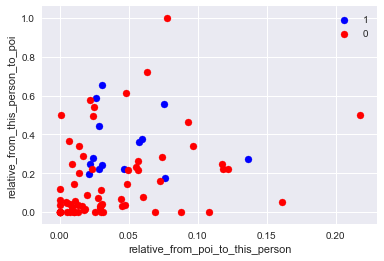

In [40]:
features = ['relative_from_poi_to_this_person','relative_from_this_person_to_poi']
labels = [1,0]
plot2Dscatter(X,y,features,labels)

Quite interestingly all the POIs have a ration of emails sent to other POI equal or above about 0.2, that is they all sent 1 email in 5 to another POI.

### Rescaling or not rescaling...

In the investigation, we want to try different kinds of algorithms for our classifier. Some of them, like SVM or k-means clustering, would behave differently whether applied to scaled or unscaled features. In our case, we decided, as explained above, not to remove the outliers in the financial features. Because of this choice, min/max scaling would not be a good approach for scaling the data. 

We decide to **start by using the unscaled features**. If we cannot manage to get the desired performance for our classifier, we will go back to this step and see which scaling method could be used.

### Feature selection

As dicussed in the previous sections, we will test 3 sets of features:
- the lists 1 and 3 differ by the used financial features ('total' vs. 'handpicked' features)
- the lists 2 and 3 differ by the used email features ('absolute' vs. 'relative' POI mail features')

We will also create, as a reference list of features, a list of 5 features among the original features, selected using SelectKBest class.

In [41]:
### The first feature must be "poi".
# List 1: 5 features
features_list1 = ['poi','total_payments','total_stock_value','shared_receipt_with_poi',\
                  'relative_from_poi_to_this_person','relative_from_this_person_to_poi'] 
# List 2: 8 features
features_list2 = ['poi','bonus','exercised_stock_options','long_term_incentive','restricted_stock','salary',\
                  'shared_receipt_with_poi','from_poi_to_this_person','from_this_person_to_poi']
# List 3: 8 features as well
features_list3 = ['poi','bonus','exercised_stock_options','long_term_incentive','restricted_stock','salary',\
                  'shared_receipt_with_poi','relative_from_poi_to_this_person','relative_from_this_person_to_poi'] 


### Extract features and labels from dataset for local testing
data1 = featureFormat(my_dataset, features_list1, sort_keys = True)
labels1, features1 = targetFeatureSplit(data1)

data2 = featureFormat(my_dataset, features_list2, sort_keys = True)
labels2, features2 = targetFeatureSplit(data2)

data3 = featureFormat(my_dataset, features_list3, sort_keys = True)
labels3, features3 = targetFeatureSplit(data3)

In [42]:
# List 4: 'best' 5 features, in teh sense of higher f-score
# Select all features except email_address
features_list4 = ['poi','bonus','deferral_payments','director_fees','exercised_stock_options','expenses',\
                  'from_messages','from_poi_to_this_person','from_this_person_to_poi','loan_advances',\
                  'long_term_incentive','other','restricted_stock','restricted_stock_deferred','salary',\
                  'shared_receipt_with_poi','to_messages','total_payments','total_stock_value'] 
# Extract features and labels from dataset
data4 = featureFormat(my_dataset, features_list4, sort_keys = True)
labels4, features4 = targetFeatureSplit(data4)
# Use SelectKBest to select the features having the 5 highest f-score
from sklearn.feature_selection import SelectKBest
Kbest_selector = SelectKBest(k=5)
features4_new = Kbest_selector.fit_transform(features4, labels4)

Let's see which features have been selected. We compare feature4_new and feature4 for the first sample:

In [43]:
print(features4_new[0])
print(features4[0])

[ 4175000.  1729541.   304805.   201955.  1729541.]
[  4.17500000e+06   2.86971700e+06   0.00000000e+00   1.72954100e+06
   1.38680000e+04   2.19500000e+03   4.70000000e+01   6.50000000e+01
   0.00000000e+00   3.04805000e+05   1.52000000e+02   1.26027000e+05
  -1.26027000e+05   2.01955000e+05   1.40700000e+03   2.90200000e+03
   4.48444200e+06   1.72954100e+06]


We see that the features index 0 ('bonus'), 3 ('exercised_stock_options'), 9 ('long_term_incentive'), 13 ('salary') and 17 ('total_stock_value') have been selected. Note that there is no email features in this selection. Let's have a look at the f-score for these features: 

In [44]:
Kbest_selector.scores_

array([ 21.06000171,   0.21705893,   2.10765594,  25.09754153,
         6.23420114,   0.1641645 ,   5.34494152,   2.42650813,
         7.2427304 ,  10.07245453,   4.20497086,   9.34670079,
         0.06498431,  18.57570327,   8.74648553,   1.69882435,
         8.86672154,  24.46765405])

The selected features have a f-score between 10 and 25.

These lists do not contain a very high number of features, and therefore we do not see the need, as a first approach, to use a dimensionality reduction technique like PCA. If the performance of the classifier is below expectetation we will go back to this step and try to use a PCA on a the list number 3.

Now we want to use a standard Naive Bayes classifier to have an idea of the difference of performance between the 4 features lists. We write a simple function to do that:

In [45]:
def NB_clf_classif_report(features, labels):
    '''Function that takes a dataset (features and labels) as input, splits it into training and test subsets
    (in stratified manner because we are dealing with imbalanced classes), creates a standard Naive Bayes classifier,
    fits it to the training data, and then displays the classification report using the test data.'''
    
    # split features and labels into training and testing sets
    from sklearn.model_selection import train_test_split
    features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)
    
    # import NB classifier from sk learn library
    from sklearn.naive_bayes import GaussianNB
    # create classifier
    clf = GaussianNB()
    
    # fit classifier using training dataset
    clf = clf.fit(features_train, labels_train)
    
    # compute recall, precision and f1-score, then display them
    from sklearn.metrics import classification_report
    labels_pred = clf.predict(features_test)
    print(classification_report(labels_test, labels_pred))# compute accuracy score

In [46]:
print('Performance with feature list nb1: ')
NB_clf_classif_report(features1, labels1)
print('')
print('Performance with feature list nb2: ')
NB_clf_classif_report(features2, labels2)
print('')
print('Performance with feature list nb3: ')
NB_clf_classif_report(features3, labels3)
print('')
print('Performance with feature list nb4: ')
NB_clf_classif_report(features4_new, labels4)

Performance with feature list nb1: 
             precision    recall  f1-score   support

        0.0       0.87      0.97      0.92        63
        1.0       0.00      0.00      0.00         9

avg / total       0.76      0.85      0.80        72


Performance with feature list nb2: 
             precision    recall  f1-score   support

        0.0       0.89      0.93      0.91        58
        1.0       0.33      0.22      0.27         9

avg / total       0.81      0.84      0.82        67


Performance with feature list nb3: 
             precision    recall  f1-score   support

        0.0       0.89      0.95      0.92        58
        1.0       0.40      0.22      0.29         9

avg / total       0.82      0.85      0.83        67


Performance with feature list nb4: 
             precision    recall  f1-score   support

        0.0       0.87      0.97      0.92        63
        1.0       0.00      0.00      0.00         9

avg / total       0.76      0.85      0.80     

When interpreting these results, we are mainly focusing in the recall and also precision for the POI class. Indeed, we are in a case of very imbalanced classification, so we want to ensure that our algorithm will be able to spot the rare positive samples in the dataset (i.e "high" recall). Given the context of this analysis, we want to give the priority at the recall over the precision. Indeed, the algorithm could be used as a first filter to detect people for which further investigation may lead to findings. The precision may not be very high, but at least we will minimize the missing of true POIs. 

Going back to the results, we see that the third list of features, containing the five financial features that seemed particularly relevant following our manual exploration of the dataset, the shared receipt email feature and also the two created email features. From now on, we use this list of features.  

In [47]:
print('Using this list of 8 features, the dataset contains {} samples among which there are {} POIs.'.\
     format(len(features3),sum(labels3)))
print('The POI class represents only {:.1%} of the dataset.'.format(sum(labels3)/len(features3)))

Using this list of 8 features, the dataset contains 133 samples among which there are 18.0 POIs.
The POI class represents only 13.5% of the dataset.


## Step 3: Algorithm choice and tuning

Here we will test 4 classifiers: Naive Bayes (NB), Support Vector Machine (SVM), k-nearest neighbors (kNN) and Decision Tree (DT). In the case of SVM, kNN and DT, we will perform a grid search to find the best parameters for these classifiers. 

To assess the performance of the classifier pending on its parameters, we will look at three metrics: recall score, precision score, and f1-score.

In [48]:
# split features and labels into training (50%) and testing (50%) sets, 
# in stratified manner because we are dealing with imbalanced classes
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features3, labels3, test_size=0.5, random_state=42, stratify=labels3)

### Naive Bayes

We do not perform any specific tuning of the parameters here.

In [49]:
# import NB classifier from sk learn library
from sklearn.naive_bayes import GaussianNB
# create classifier
clf = GaussianNB()
    
# fit classifier using training dataset
clf = clf.fit(features_train, labels_train)
    
# compute recall, precision and f1-score, then display them
from sklearn.metrics import classification_report
labels_pred = clf.predict(features_test)
print(classification_report(labels_test, labels_pred))

             precision    recall  f1-score   support

        0.0       0.89      0.95      0.92        58
        1.0       0.40      0.22      0.29         9

avg / total       0.82      0.85      0.83        67



The recall of POIs is below target (0.3).

### SVM

In this case we perform a grid search, trying:
- two different kernel types: rbf and sigmoid. Based on the visualization we did before, we think it would be difficult for a linear kernel to be able to separate well between POIs and non-POIs.
- three different values for the gamma kernel coefficient: 1, 0.1 and 0.01
- four different values for the penalty parameter C: 10, 100, 1000 and 10000

In [50]:
# Dictionary of the parameters, and the possible values they may take. 
# Based on the visualization we did before, we think it difficult for a linear kernel to 
# be able to separate well between POIs and non-POIs. We therefore limit our grid to a rbf kernel.
# We try 3 diferent C (possible choices are 10, 100 and 1000), and 
# 2 different values for gamma (0.1 and 0.01)
parameters = {'kernel':['rbf','sigmoid'], 'gamma': [1, 0.1, 0.01], 'C': [10, 100, 1000, 10000]}

In [51]:
# We first create only the 'algorithm object, that is, the classifier and the possible sets of parameters
# we set the class_weight parameters to 'balanced' to give more weight to the unfrequent class (POIs)
from sklearn.svm import SVC
svc = SVC(class_weight = 'balanced')

In [52]:
# We pass the algorithm (svc) and the dictionary of parameters to try (parameters) and 
# it generates a grid of parameter combinations to try.
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(svc, parameters, scoring = 'recall')

In [53]:
# The fit function now tries all the parameter combinations, 
# and returns a fitted classifier that's automatically tuned to the optimal parameter combination.
clf.fit(features_train,labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'sigmoid'], 'gamma': [1, 0.1, 0.01], 'C': [10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

Now, for the display of the grid search results, we define the function below:

In [54]:
def grid_results_display(clf, features_test, labels_test):
    '''Function that takes a gridsearch fitted classifier, the test features and labels as input, 
    and displays the best combination of parameters, the grid scores for the different combinations of the grid
    and finally the classification report for the best combination (using the test data).
    # For this function, we re-used and adapted an example found in the sklearn documentation (ref in references.txt)'''

    print('Best parameters set found on training set:')
    print()
    print(clf.best_params_)
    print()
    print('Grid scores on training set:')
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print('{:.3f} (+/-{:.03f}) for {}'.format(mean, std * 2, params))
    print()
    print('Detailed classification report:')
    print()
    print('The model is trained on the full training set.')
    print('The scores are computed on the full test set.')
    print()
    labels_pred = clf.predict(features_test)
    print(classification_report(labels_test, labels_pred))
    print()

In [55]:
grid_results_display(clf, features_test, labels_test)

Best parameters set found on training set:

{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}

Grid scores on training set:

0.000 (+/-0.000) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.667 (+/-0.544) for {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.667 (+/-0.544) for {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.667 (+/-0.544) for {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.000 (+/-0.000) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.667 (+/-0.544) for {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}
0.000 (+/-0.000) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.667 (+/-0.544) for {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.000 (+/-0.000) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.667 (+/-0.544) for {'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.000 (+/-0.000) for {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
0.667 (+/-0.544) for {'C': 1000, 'gamma': 1, 'kern

The only tested parameter that has an effect in our classification task seems to be the kernel: sigmoid kernel works better than rbf kernel. Nevertheless, the precision of POI detection is very low and below target (0.3).  

### kNN

In this case also we will perform a grid search, trying:
- five different numbers of neighbors: 2, 3, 4, 5, 6 
- three different algorithms: ‘ball_tree’, ‘kd_tree’, ‘brute’

In [56]:
# dictionary of parameters
parameters = {'n_neighbors': [2, 3, 4, 5, 6], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}

In [57]:
# create algorithm object
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()

In [58]:
# create classifier from algorithm and dictionary of parameters using GridSearchCV
clf = GridSearchCV(neigh, parameters, scoring = 'recall')

In [59]:
# Fit the classifier (tries all the parameter combinations)
clf.fit(features_train,labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6], 'algorithm': ['ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

In [60]:
grid_results_display(clf, features_test, labels_test)

Best parameters set found on training set:

{'algorithm': 'ball_tree', 'n_neighbors': 3}

Grid scores on training set:

0.000 (+/-0.000) for {'algorithm': 'ball_tree', 'n_neighbors': 2}
0.111 (+/-0.314) for {'algorithm': 'ball_tree', 'n_neighbors': 3}
0.000 (+/-0.000) for {'algorithm': 'ball_tree', 'n_neighbors': 4}
0.000 (+/-0.000) for {'algorithm': 'ball_tree', 'n_neighbors': 5}
0.000 (+/-0.000) for {'algorithm': 'ball_tree', 'n_neighbors': 6}
0.000 (+/-0.000) for {'algorithm': 'kd_tree', 'n_neighbors': 2}
0.111 (+/-0.314) for {'algorithm': 'kd_tree', 'n_neighbors': 3}
0.000 (+/-0.000) for {'algorithm': 'kd_tree', 'n_neighbors': 4}
0.000 (+/-0.000) for {'algorithm': 'kd_tree', 'n_neighbors': 5}
0.000 (+/-0.000) for {'algorithm': 'kd_tree', 'n_neighbors': 6}
0.000 (+/-0.000) for {'algorithm': 'brute', 'n_neighbors': 2}
0.111 (+/-0.314) for {'algorithm': 'brute', 'n_neighbors': 3}
0.000 (+/-0.000) for {'algorithm': 'brute', 'n_neighbors': 4}
0.000 (+/-0.000) for {'algorithm': 'brute', 

The kNN classifier works with reasonable recall and precision when tuned with a number of neighbors of 3, with no notable difference between the different algorithm we tested. 

### Decision Tree

In this case we also perform a grid search, trying:
- two kinds of criterions: 'gini' and 'entropy'
- four different max_depth parameters: 1, 2, 4 and 8
- three different min_samples_split settings: 2, 4 and 8 

In [61]:
# dictionary of parameters
parameters = {'criterion': ['gini','entropy'], 'max_depth': [1, 2, 4, 8], 'min_samples_split': [2, 4, 8]}

In [62]:
# create algorithm object
# we set the class_weight parameters to 'balanced' to give more weight to the unfrequent class (POIs)
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight = 'balanced')

In [63]:
# create classifier from algorithm and dictionary of parameters using GridSearchCV
clf = GridSearchCV(dt, parameters, scoring = 'recall')

In [64]:
# Fit the classifier (tries all the parameter combinations)
clf.fit(features_train,labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 4, 8], 'min_samples_split': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

In [65]:
grid_results_display(clf, features_test, labels_test)

Best parameters set found on training set:

{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}

Grid scores on training set:

0.667 (+/-0.544) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
0.667 (+/-0.544) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 4}
0.667 (+/-0.544) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 8}
0.444 (+/-0.314) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}
0.444 (+/-0.314) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4}
0.444 (+/-0.314) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 8}
0.444 (+/-0.314) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}
0.444 (+/-0.314) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4}
0.444 (+/-0.314) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 8}
0.444 (+/-0.314) for {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2}
0.444 (+/-0.314) for {'criterion'

We achieve the best performance so far with a decision tree classifier with a maximum_depth parameter of 1. With such value for maximum_depth, the type of criterion (gini or entropy) and the min_samples_split parameters seem to have little effect. 

We propose to submit this algorithm (Decision Tree classifier, {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}) for test using the tester code. Note that we also set the class_weight setting to 'balanced' because we want to give more weight to the POIs samples (see sklearn DT classifier documentation).

In [68]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=1, min_samples_split=2, class_weight='balanced')

## Step4: validation and evaluation

We start by dumping the classifier, the selected features and corresponding data:

In [69]:
dump_classifier_and_data(clf, my_dataset, features_list3)

Now we use the tester.py (modified so that to work with model_selection.StratifiedShuffleSplit instead of the previous version cross_validation.StratifiedShuffleSplit). As stated in the starter code, "because of the small size of the dataset, the script uses stratified shuffle split cross validation.

In [70]:
%run tester.py

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.76071	Precision: 0.32989	Recall: 0.65450	F1: 0.43867	F2: 0.54688
	Total predictions: 14000	True positives: 1309	False positives: 2659	False negatives:  691	True negatives: 9341



After this evaluation based on 1000 folds of the initial dataset, the proposed set of features together with the tuned classifier reach a recall of 0.6 and a precision slightly above 0.3.